# FORCAST Grism Spectra: Quick Custom Spectral Extraction


## Introduction

This recipe provides an overview and sample code (in Python) for custom spectral extractions from the LEVEL_2 2-D rectified images produced by the FORCAST pipeline.  We recommend that the user review the first FORCAST Grism Recipe ("Basic Inspection and Assessment") before proceeding with this slightly more advanced one.  

Raw FORCAST data suffers from several instrumental artifacts.  Nearly all of the artifacts are removed or corrected by the Level 2 FORCAST pipeline, including: bad pixels; the Droop effect; non-linear pixel response; and the “jailbar” effect.  In addition, the grism pipeline extracts the one-dimensional spectra, applies both wavelength and flux calibration, and corrects for telluric absorption.   For point sources, an "optimal extraction" algorithm is used, while for extended (non-point-like) sources, a standard summation over the aperture is used (see recipe on extended soruces for additional information on custom extractions).  See the [FORCAST GO Data Handbook] for details regarding the artifacts, pipeline algorithms, and the flux-calibration process.  

The extraction aperture for extended sources is generally set manually to include all the flux from the source and may not be exactly what the GI needs for his or her science.  In this recipe we show the user how to plot the aperture used on the 2-D spectral image and how to do a simple custom extraction using a different aperture.  If a custom extraction is needed, we strongly encourage the GI to contact the SOFIA Science Center and request re-reduction with the specifed aperture(s).  This ensures that the GI gets the best quality data using the latest pipeline routines.

## Ingredients

1. Level 3 (flux calibrated) FORCAST grism data (either CAL or CMB files) from the [SOFIA Archive] and the accompanying LEVEL_2 RIM file(s) for each CAL or CMB file.
    - You can obtain the RIM files for a given AOR by using the Advanced Search Page and specifying:
        - Processing State: LEVEL_2
        - Product Type: rectimage
    - The accompanying RIM files will have the same name as the CAL/CMB files, except with "RIM" in the middle of the name instead of "CAL"/"CMB" (see example below).    
2.  Sample Data (if desired):  In this example we will be using observations of the PN NGC 7009 (PI:TBD).  
    - Level 3 data can be obtained from the DCS Archive using the following search criteria (under Advanced Search):
        - MissionID = "2017-08-07_FO_F428"
        - Instrument/Config = "FORCAST/Grism"
        - Processing State = "LEVEL_3" 
        - Target = "NGC 7009" 
      Download all data adn save to local desktop.  
    - To get the LEVEL_2 RIM files use the exact same search along with:
        - Processing State = "LEVEL_2"
        - Product Type = "rectimage"
      And again download all the data and save to local desktop.  
    - For this example we will be using the following files:  
        - F0428_FO_GRI_0500637_FORG111_CAL_0177-0196.fits
        - F0428_FO_GRI_0500637_FORG111_RIM_0177-0196.fits
      For convenience, we recommend saving in a folder called "forcast-sample-data" in the same directory as this Python Notebook.
3. [FORCAST GO Handbook] for reference (latest version can be found on the [SOFIA Data Products and Archives page])
4. Download and install [APLpy](https://aplpy.github.io/)

## Inspecting the Extraction Aperture

Our first task si to determine what aperture was used with the default pipeline extraction and plot it on the 2-D rectified image for evaluation.  First load the CAL and RIM files and plot the extracted spectrum from the CAL file:

/Users/rshuping/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


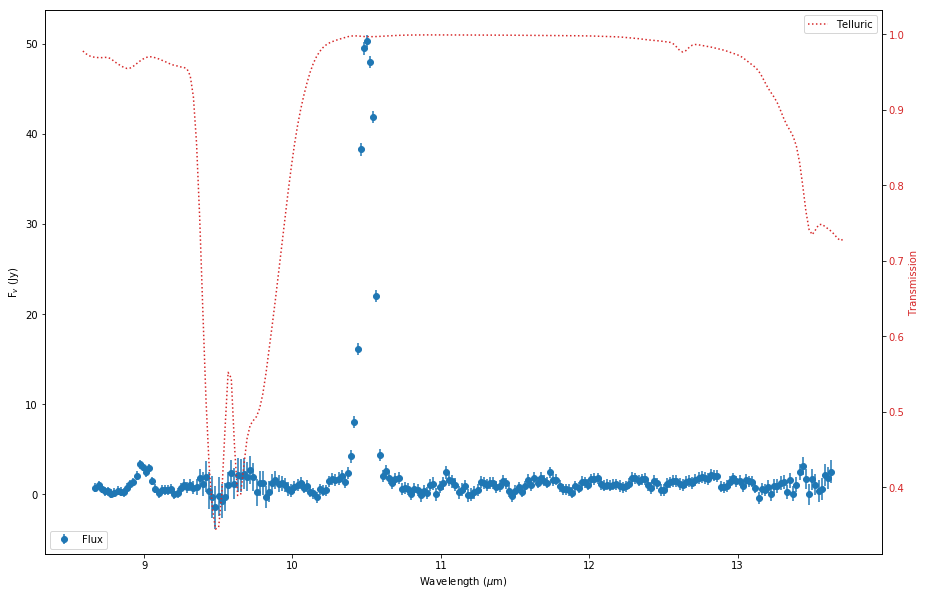

In [1]:
from astropy.io import fits
from astropy.table import Column
from astropy.table import Table
from astropy import constants as const
from astropy import units as u
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
from aplpy import FITSFigure
import numpy as np

#Define a function for loading fits data into tables with units
def loadFORCASTGrismData(filename):
    #Now open fits file for the sample data...
    data_fits = fits.open(filename)

    #... read the data portion of the file into a separate array:
    data_tmp = data_fits[0].data

    #... load into table for convenience
    data_table = Table([data_tmp[0],data_tmp[1],data_tmp[2],data_tmp[3],data_tmp[4]], 
                  names=('wavelength', 'flux', 'error', 'telluric', 'response'), masked = True,
                  meta={'name': 'Data Table'})

    #and assign units.
    data_table['wavelength'].unit = 'micron'
    data_table['flux'].unit = 'Jy'
    data_table['error'].unit = 'Jy'
    data_table['response'].unit = 'Jy/s'
    
    return data_fits,data_table


#Calibrated data file on local disk:
calfile = 'forcast-sample-data/F0428_FO_GRI_0500637_FORG111_CAL_0177-0196.fits'

#Load fits data and tabular data...
g111_fits, g111_tab=loadFORCASTGrismData(calfile)

#And plot flux and telluric spectra
fig, ax1 = plt.subplots(figsize=(15,10))

ax1.set_xlabel('Wavelength ($\mu$m)')
ax1.set_ylabel('F$_v$ (Jy)')
ax1.errorbar(g111_tab['wavelength'],g111_tab['flux'],yerr=g111_tab['error'],fmt='o',label="Flux")
ax1.legend(loc="lower left")

color = 'tab:red'
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Transmission', color=color)
ax2.plot(g111_tab['wavelength'],g111_tab['telluric'], color=color, linestyle=':',label="Telluric")
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend()

Now suppose we want to take a look at the 2-D spectral image from which this extraction was made.  The recitified 2-d images are stored in the LEVEL_2 "RIM" file ("F0428_FO_GRI_0500637_FORG111_RIM_0177-0196.fits").  Easiest way to quickly read and display this file is to use AplPy (remember that FORCAST image data is stored in 3-D data "cubes" where the first plane is flux):

INFO: Auto-setting vmin to -3.698e-03 [aplpy.core]
INFO: Auto-setting vmax to  1.180e-02 [aplpy.core]


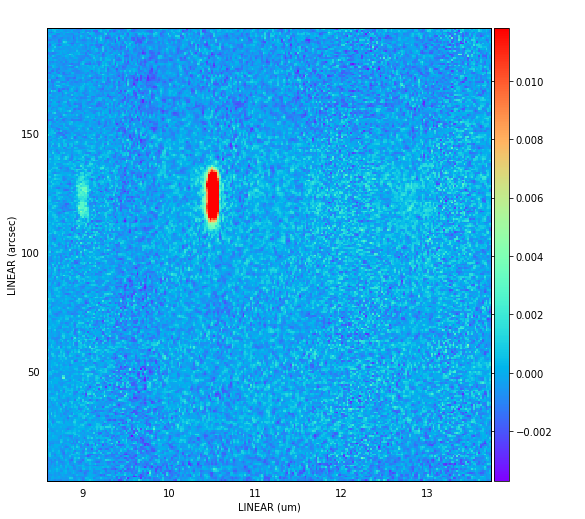

In [2]:
#Load RIM file...
rimfile = 'forcast-sample-data/F0428_FO_GRI_0500637_FORG111_RIM_0177-0196.fits'
g111rim_fits = fits.open(rimfile)

#And now display 2-d image from RIM file
cmap = 'rainbow'
axs = FITSFigure(g111rim_fits, slices = [0]) #0-th slice contains flux
axs.show_colorscale(cmap=cmap)
axs.add_colorbar()

AplPy applies the CD matrix in the FITS header to the data, which will make the next step (aperture display) a little easier.  So here you can see there appears to be a strong line around 10.6 $\mu$m and a weaker one at 9 $\mu$m.  Since this is clearly not a resolved point source, the user might want to know what aperture was used for the 1-d extraction.  The aperture position and radius is stored in the *CAL* file header using the FITS keywords "APPOSO01" and "APRADO01" in units of *arcsec*, so lets grab those values and display them:

In [3]:
#Find apertures for G111 extraction, [position (arcsec),radius (arcsec)]
g111_ap = [float(g111_fits[0].header['APPOSO01']),
           float(g111_fits[0].header['APRADO01'])]
print,g111_ap

(<function print>, [120.0, 20.0])

So the aperture used for the extraction was centered at 120 arcsec with a radius of +/- 20 arcsec, which we can now plot on teh 2-D rectified image:

INFO: Auto-setting vmin to -3.698e-03 [aplpy.core]
INFO: Auto-setting vmax to  1.180e-02 [aplpy.core]


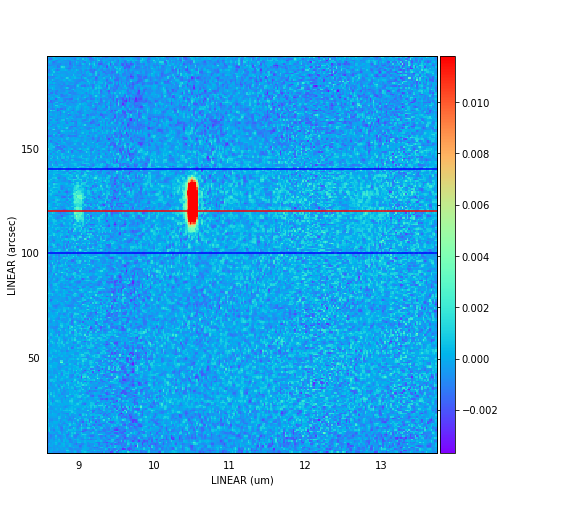

In [4]:
#Display the image again
cmap = 'rainbow'
axs = FITSFigure(g111rim_fits, slices = [0])
axs.show_colorscale(cmap=cmap)
axs.add_colorbar()

cent=g111_ap[0]
rad=g111_ap[1]

#Define center line, and low/hi limits using simple numpy array: [[x1, x2],[y1,y2]]
ap_cent = np.array([[8, 14],[cent,cent]])
ap_lo = np.array([[8, 14],[cent-rad,cent-rad]])
ap_hi = np.array([[8, 14],[cent+rad,cent+rad]])

#and now use matplotlib.showlines to overplot the lines on the 2-D image.
axs.show_lines([ap_cent], color = 'r')
axs.show_lines([ap_lo], color = 'b')
axs.show_lines([ap_hi], color = 'b')

## Quick Custom Spectral Extractions

To make a custom extraction, the user will need the original CAL (or CMB) file (for the telluric and response spectra), the corresponding RIM file, and the size and location of the desired aperture(s). In the example above, the aperture used appears to be a little large and slightly misaligned.  We recommend that the user first explore the RIM file using a separate image analysis tool like DS9 in order to identify the exact location and size of the desired apertures.  In the case above, using DS9, we see the the spectral line at ~10.5 $\mu$m is double-peaked in the spatial direction:

![2-D Image](figs/ds9_image.png)

Which is even more obvious from the simple spatial extraction along the slit in teh plot below:

![Line Plot](figs/ds9_plot.png)

The spatial separation of the two peaks is approximately 10 pixels, which corresponds to ~7.7 arcsec. Since the FWHM of the PSF at 11 $\mu$m is typically <3.0 arcsec, this indicates that the two peaks are likely to be real (which might be excpected for a planetary nebula) and we might want to extract spectra for each separately in order to compare the line flux from each position. Using DS9, we estimate the approximate locations and widths of each new aperture (1 and 2) *in pixel space*:
-   Aperture 1
    - Center:  162
    - Width: 16
- Aperture 2
    - Center: 147
    - Width: 11

NOTE:  normally we would also identify "sky" regions for subtraction.  Since the RIM file has already been sky-subtracted, the background is very close to zero and should not make a huge difference in the results of this "quick" extraction.

We will need to first extract the image array from the RIM file.  Remember that the RIM data is a data *cube* containing flux (0), variance (1), and coverage (2).  We only need the flux array for this exercise:

In [5]:
#Read the data portion of the file into a separate array for convenience.
tmp = g111rim_fits[0].data
g111_rim = tmp[0,:,:]  #0th plane contains the flux.

Now define our apertures and plot them on the RIM image.

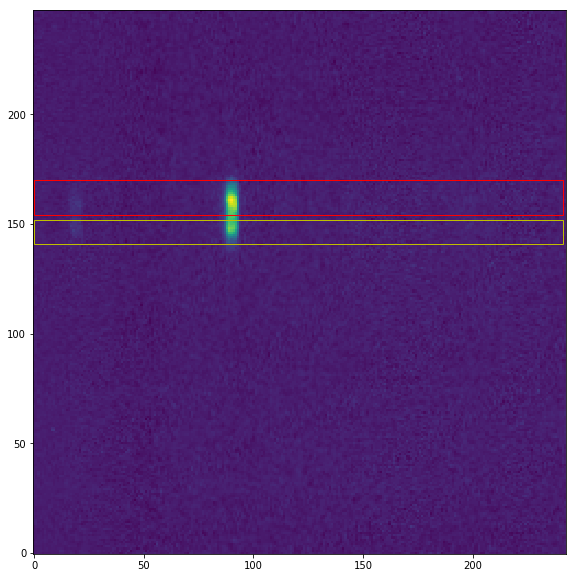

In [6]:
#original aperture from pipeline reduction as reference.
#ap0_cent = 150
#ap0_width = 50 

#Define new apertures:
ap1_cent = 162
ap1_width = 16
ap2_cent = 147
ap2_width = 11

#and convert to integer arrays:
ap1 = np.array([ap1_cent-0.5*ap1_width,ap1_cent+0.5*ap1_width],dtype='int_')
ap2 = np.array([ap2_cent-0.5*ap2_width,ap2_cent+0.5*ap2_width],dtype='int_')

# Create figure and axes
fig,ax = plt.subplots(1,figsize=(15,10))

# Display the RIM image
ax.imshow(g111_rim,origin='lower')

# Create a Rectangle patch for each aperture:
ap1_patch = patches.Rectangle((0,ap1[0]),241,ap1_width,
                             linewidth=1,edgecolor='r',facecolor='none')
ap2_patch = patches.Rectangle((0,ap2[0]),241,ap2_width,
                             linewidth=1,edgecolor='y',facecolor='none')

# Add the patches
ax.add_patch(ap1_patch)
ax.add_patch(ap2_patch)

plt.show()

Since the 2-D RIM file is already wavelength rectified and calibrated, all we need to do is sum the data in each aperture over the spatial dimension to get the flux (in Me/s) at each wavelength in the CAL file wavelength array.  In order to flux calibrate, simply divide by the telluric and response sepctra provided in the CAL file that we loaded earlier in the recipe.  Note however, that for Nod-Match-Chop mode (NMC) the central (positive) source is *doubled* after stacking, so a factor of 0.5 must be applied to account for this doubling.  

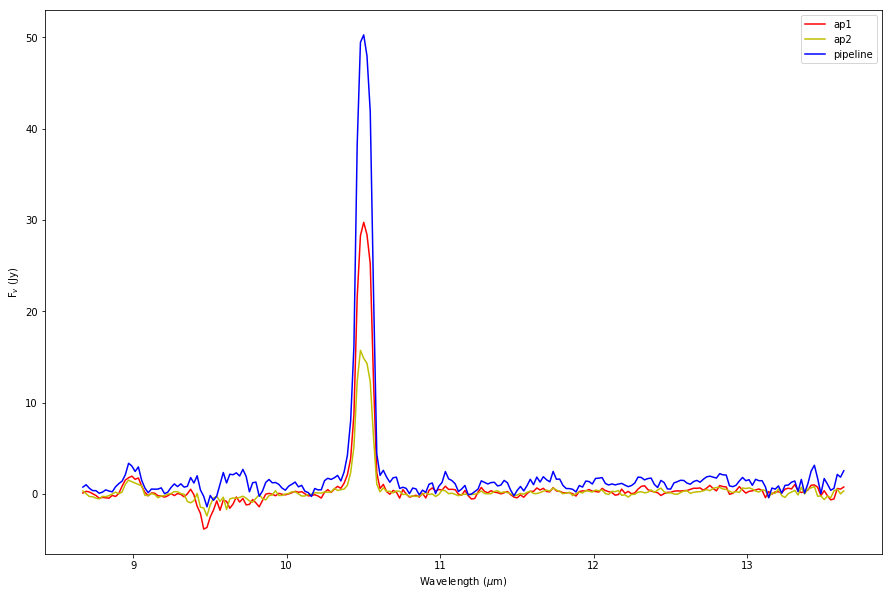

In [7]:
#Sum RIM data over spatial dimension of each aperture,
#and apply telluric correction and response function to flux calibrate,
#and dont forget extra factor of 0.5 for nod beam correction.
flux1 = 0.5*np.sum(g111_rim[ap1[0]:ap1[1],:242],axis=0) / g111_tab['telluric'] / g111_tab['response']
flux2 = 0.5*np.sum(g111_rim[ap2[0]:ap2[1],:242],axis=0) / g111_tab['telluric'] / g111_tab['response']

#Since the wavelength solution in the CAL file is *derived* from the RIM file,
#we can simply plot the resulting flux arrays for each aperture against the wavelength array 
#in the CAL file.
plt.figure(figsize=(15,10))
plt.plot(g111_tab['wavelength'], flux1, label='ap1', color='r')
plt.plot(g111_tab['wavelength'], flux2, label='ap2', color='y')
#and plot the default pipeline output for comparison.
plt.plot(g111_tab['wavelength'], g111_tab['flux'], label='pipeline', color='b')
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('F$_v$ (Jy)')
plt.legend()

We can see from this simple double aperure extraction that the lineflux in the "upper" part of the PN (aperture 1) is about twice that in the "lower" part (aperture 2).  This quick extraction method is a good way to explore the data and decide whether a re-reduction should be requested from the SOFIA Science Center.  If the user finds that a re-extraction with different aperture(s) is warranted by this quick-look method, we encourage him or her to contact the SSC with a re-reduction request. 